In [102]:
from __future__ import print_function, division
import tensorflow as tf
import librosa
import os
import numpy as np
from IPython.display import Audio, display
import matplotlib.pyplot as plt
%matplotlib inline

### Load style and content

In [8]:
CONTENT_FILENAME = "inputs/spongebob.mp3"
STYLE_FILENAME = "inputs/gettysburg.mp3"

In [9]:
display(Audio(CONTENT_FILENAME))
display(Audio(STYLE_FILENAME))

In [10]:
# Reads wav file and produces spectrum
# Fourier phases are ignored
N_FFT = 2048
def read_audio_spectum(filename):
    x, fs = librosa.load(filename)
    S = librosa.stft(x, N_FFT)
    #p = np.angle(S)
    
    S = np.log1p(np.abs(S[:,:430]))  
    return S, fs

In [11]:
a_content, fs = read_audio_spectum(CONTENT_FILENAME)
a_style, fs = read_audio_spectum(STYLE_FILENAME)

N_CHANNELS = a_content.shape[0]
N_SAMPLES = a_content.shape[1]
a_style = a_style[:N_CHANNELS, :N_SAMPLES]

---
### Some testing code (safe to ignore) ###

In [47]:
raw_audio = librosa.load(CONTENT_FILENAME)
S = librosa.stft(a[0], n_fft = 2048)

In [48]:
#print( a )
print( raw_audio[0].shape )
print( S.shape )

(220632,)
(1025, 431)


In [57]:
print(S[:2,:2])
print(S.shape, S.dtype, end="\n\n")

magnitude_S = np.abs(S)
print(magnitude_S[:2,:2])
print(magnitude_S.shape, magnitude_S.dtype, end="\n\n")

angle_S = np.angle(S)
print(angle_S[:2,:2])
print(angle_S.shape, angle_S.dtype)
# angle_S.min() #-> -3.1415927

[[ -4.96608973 -0.00000000e+00j  -5.88092375 -0.00000000e+00j]
 [ 10.22114658 -7.13838710e-16j  -3.62930012 +1.53553212e+00j]]
(1025, 431) complex64

[[  4.96608973   5.88092375]
 [ 10.22114658   3.94077134]]
(1025, 431) float32

[[ -3.14159274e+00  -3.14159274e+00]
 [ -6.98393951e-17   2.74133825e+00]]
(1025, 431) float32


-3.1415927

In [29]:
220632*4/2048 # number of windows in audio

430.921875

In [70]:
l = np.ascontiguousarray(magnitude_S.T[np.newaxis, np.newaxis, :, :])
print(l.shape)
print()
print(l.flags)

(1, 1, 431, 1025)

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False


---

### Visualize spectrograms for content and style tracks

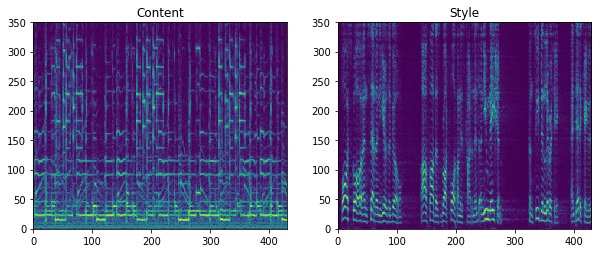

In [77]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Content')
plt.imshow(a_content[:350,:], origin='lower')

plt.subplot(1, 2, 2)
plt.title('Style')
plt.imshow(a_style[:350,:], origin='lower')

plt.show()

### Compute content and style feats

---

In [53]:
np.random.randn(2,3)

array([[ 1.03351908, -0.13508478,  0.29636149],
       [ 0.26834541,  0.420933  ,  0.25326901]])

In [81]:
N_FILTERS = 4096
std1 = np.sqrt(2) * np.sqrt(2.0 / ((N_CHANNELS + N_FILTERS) * 11))
std2 = 2 * np.sqrt(1.0 / ((N_CHANNELS + N_FILTERS) * 11))
print(std1)
print(std1 == std2)

0.00842667540345
True


---

In [83]:
print(N_CHANNELS)

1025


In [78]:
N_FILTERS = 4096

a_content_tf = np.ascontiguousarray(a_content.T[np.newaxis,np.newaxis,:,:])
a_style_tf   = np.ascontiguousarray(a_style  .T[np.newaxis,np.newaxis,:,:])

# filter shape is "[filter_height, filter_width, in_channels, out_channels]"
std = np.sqrt(2) * np.sqrt(2.0 / ((N_CHANNELS + N_FILTERS) * 11)) # standard deviation
kernel = std * np.random.randn(1, 11, N_CHANNELS, N_FILTERS)

In [92]:
g = tf.Graph()
with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
    # data shape is "[batch, in_height, in_width, in_channels]",
    x = tf.placeholder('float32', [1,1,N_SAMPLES,N_CHANNELS], name="x")
    
    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    conv = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv")
    
    net = tf.nn.relu(conv)
    
    content_features = net.eval(feed_dict={x: a_content_tf})
    style_features = net.eval(feed_dict={x: a_style_tf})
    
    features = np.reshape(style_features, (-1, N_FILTERS))
    style_gram = np.matmul(features.T, features) / N_SAMPLES

TypeError: Value passed to parameter 'input' has DataType string not in list of allowed values: float16, float32, float64

In [101]:
print(N_SAMPLES, N_FILTERS)
print(content_features.shape)
print(features.shape)
print(style_gram.shape)

430 4096
(1, 1, 420, 4096)
(420, 4096)
(4096, 4096)


### Optimize

In [15]:
from sys import stderr

ALPHA= 1e-2
learning_rate= 1e-3
iterations = 100

result = None
with tf.Graph().as_default():
    
    # Build graph with variable input
#     x = tf.Variable(np.zeros([1,1,N_SAMPLES,N_CHANNELS], dtype=np.float32), name="x")
    x = tf.Variable(np.random.randn(1,1,N_SAMPLES,N_CHANNELS).astype(np.float32)*1e-3, name="x")
    
    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    conv = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv")
    
    
    net = tf.nn.relu(conv)
    
    content_loss = ALPHA * 2 * tf.nn.l2_loss(net - content_features)
    #style_loss = 0
    
    _, height, width, number = map(lambda i: i.value, net.get_shape())
    
    size = height * width * number
    feats = tf.reshape(net, (-1, number))
    gram = tf.matmul(tf.transpose(feats), feats)  / N_SAMPLES
    style_loss = 2 * tf.nn.l2_loss(gram - style_gram)
    
     # Overall loss
    loss = content_loss + style_loss
    
    opt = tf.contrib.opt.ScipyOptimizerInterface(
          loss, method='L-BFGS-B', options={'maxiter': 300})
    
    # Optimization
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        print('Started optimization.')
        opt.minimize(sess)
        
        print('Final loss:', loss.eval())
        result = x.eval()

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Started optimization.
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1502.823486
  Number of iterations: 290
  Number of functions evaluations: 367
Final loss: 1502.82


In [99]:
net.get_shape()

TensorShape([Dimension(1), Dimension(1), Dimension(420), Dimension(4096)])

### Invert spectrogram and save the result

In [93]:
a = np.zeros_like(a_content)
a[:N_CHANNELS,:] = np.exp(result[0,0].T) - 1

# This code is supposed to do phase reconstruction
p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
for i in range(500):
    S = a * np.exp(1j*p)
    x = librosa.istft(S)
    p = np.angle(librosa.stft(x, N_FFT))

In [94]:
OUTPUT_FILENAME = 'outputs/spongebob.wav'
librosa.output.write_wav(OUTPUT_FILENAME, x, fs)

In [96]:
print(OUTPUT_FILENAME)
display(Audio(OUTPUT_FILENAME))

outputs/spongebob.wav


ValueError: could not convert string to float: 'outputs/spongebob.wav'

### Visualize spectrograms

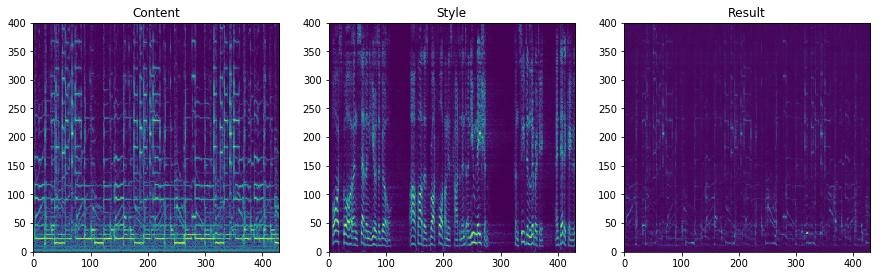

In [74]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Content')
plt.imshow(a_content[:400,:], origin='lower')
plt.subplot(1,3,2)
plt.title('Style')
plt.imshow(a_style[:400,:], origin='lower')
plt.subplot(1,3,3)
plt.title('Result')
plt.imshow(a[:400,:], origin='lower')
plt.show()